In [1]:
import matplotlib.pyplot as plt
import math
import itertools
import pandas as pd
import numpy as np
import random
from scipy import stats
from scipy.stats import poisson
from scipy.stats import chisquare
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from fractions import Fraction

In [24]:
class PRNG:
    def get_next_digit(self):
        return random.choice([0,1])
    
class Levin2:
    
    def __init__(self):
        self.file = open('levin_q2.txt')
        
    def get_next_digit(self):
        c = self.file.read(1)
        if not c:
            raise Exception('No more digits')
        return c
    lenc = 0

In [6]:
def get_M(N,lamb):
    return int(math.ceil(math.log(N,2) - math.log(lamb,2)))

def normalize_data(occs, N, lamb):
    M = get_M(N,lamb)
    ret = []
    for o in occs:
        ret.append(o/2**M)
    return ret

def get_mean(normalized_occs):
    mean = 0
    for i in range(len(normalized_occs)):
        mean += i*normalized_occs[i]
    return mean

def get_std(normalized_occs,mean):
    if mean == None:
        mean = get_mean(normalized_occs)
        
    std = 0
    for i in range(len(normalized_occs)):
        std += ((i-mean)**2)*normalized_occs[i]
    return std

In [5]:
def get_occurrences(amounts,M):
    #returns frequency of occurencies for each value in the observed range
    occs = {}
    total = 0    
    for k,v in amounts.items():
        total += 1
        if v not in occs:
            occs[v] = 0
        occs[v] = occs[v] + 1
    occs[0] = int(2**M - total)
    max_o = 0
    for k,v in occs.items():
#         occs[k] = v/2**M
        occs[k] = v
        if k > max_o:
            max_o = k
    occs_array = [occs[i] if i in occs  else 0 for i in range(max_o+1)]
    return occs_array

In [13]:
def get_amounts(N,lamb=1,use_seq='PRNG'):
    if use_seq == 'levin':
        sequence = Levin()
    elif use_seq == 'levin2':
        sequence = Levin2()
    elif use_seq == 'champernowne':
        sequence = Champernowne()
    elif use_seq == 'rule30':
        sequence = Rule30()
    elif use_seq == 'stoneham':
        sequence = Stoneham()
    else:
        sequence = PRNG()
        
        
    M = get_M(N,lamb)
    
    #create dictionaries to store frequencies of every N value
    amounts = {}
    occurrences = {}   
    counter = 0
    word = ''
    
    
    while counter < N * M:
        
        #Get digits up to M
        while len(word) < M:
            counter += 1
            word = word + str(sequence.get_next_digit())

        if word not in amounts:
            amounts[word] = 0
        amounts[word] = amounts[word] + 1

        word = ''
        
    return get_occurrences(amounts,M)

In [9]:
def analize_result(occs,N,l=1,plot=True):
    print("---- Normalized data ----")
    actual = np.array(normalize_data(occs,N,l))
    M = int(math.ceil(math.log(N,2)))    
    x= np.arange(0,len(actual),1)
    p = poisson.pmf(x,l)
    mean = get_mean(actual)
    std = get_std(actual,mean)
    print ("Mean: "+ str(mean) + "; expected: " + str(l) + "; difference: " + str(abs(l-mean)))
    print ("Std: "+ str(std) + "; expected: " + str(l) + "; difference: " + str(abs(l-std)))
    print("difference between std and mean :"+  str(abs(mean-std)))
    print("MWU: " + str(mannwhitneyu(actual,p)))
    print("Levene: " + str(levene(actual,p)))
    if(plot):
        plt.figure(l)
        plt.plot(x, p)
        p2 = plt.bar(x-0.5, p,label="expected",width=0.5)
        p1 = plt.bar(x, actual, color='#d62728',label="actual",width=0.5)
        plt.legend(loc='best')
        plt.show()
#         plt.figure(l+1)
#         stats.probplot(actual, dist='poisson', sparams=(l), plot=plt)
#         plt.show()

def analize_result_2(occs,l=1,plot=True):
    print("---- Sample data ----")
    actual = np.array(occs)
    sample = poisson.rvs(1, size=sum(occs))
    expected = [0 for i in range(max(max(sample)+1,len(actual)))]
    for i in sample:
        expected[i] += 1
    expected = np.array(expected)
    x= np.arange(0,len(actual),l)
#     print("chisquare: " + str(chisquare(f_obs=actual, f_exp=expected)))
    print("MWU: " + str(mannwhitneyu(actual,expected)))
    print("Levene: " + str(levene(actual,expected)))
    
    data_by_index = []
    for i in range(len(occs)):
        for j in range(occs[i]):
            data_by_index.append(i)
    
    if(plot):
#         plt.figure(l)
#         plt.plot(x, expected)
#         p2 = plt.bar(x-0.5, expected,label="expected",width=0.5)
#         p1 = plt.bar(x, actual, color='#d62728',label="actual",width=0.5)
#         plt.legend(loc='best')
#         plt.show()
        plt.figure(l+1)
        stats.probplot(data_by_index, dist='poisson', sparams=(l), plot=plt)
        plt.show()

In [22]:
def perform_test(seq,N=2**25,lamb=1):
    occs = get_amounts(N,lamb=lamb,use_seq=seq)
    analize_result(occs,N,plot=True,l=lamb)
    analize_result_2(occs,plot=True,l=lamb)

---- Normalized data ----
Mean: 1.0; expected: 1; difference: 0.0
Std: 1.0001747608184814; expected: 1; difference: 0.0001747608184814453
difference between std and mean :0.0001747608184814453
MWU: MannwhitneyuResult(statistic=59.0, pvalue=0.47381488164049806)
Levene: LeveneResult(statistic=2.7857650750252405e-12, pvalue=0.9999986851309083)


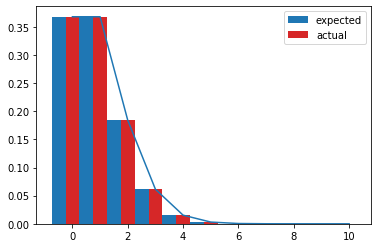

---- Sample data ----
MWU: MannwhitneyuResult(statistic=60.0, pvalue=0.5)
Levene: LeveneResult(statistic=1.0981522441128918e-11, pvalue=0.9999973886757344)


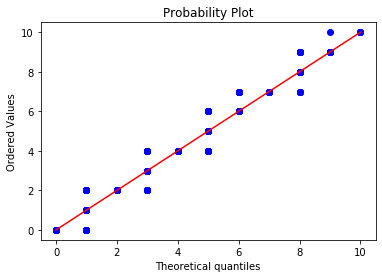

In [23]:
perform_test('PRNG')

---- Normalized data ----
Mean: 1.0; expected: 1; difference: 0.0
Std: 0.9516925811767578; expected: 1; difference: 0.04830741882324219
difference between std and mean :0.04830741882324219
MWU: MannwhitneyuResult(statistic=38.0, pvalue=0.42987378317046787)
Levene: LeveneResult(statistic=4.2857430559790505e-05, pvalue=0.9948575701420276)


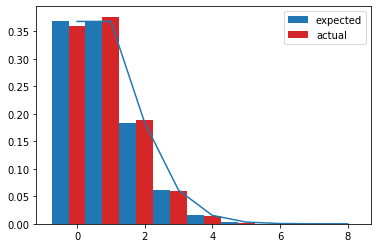

---- Sample data ----
MWU: MannwhitneyuResult(statistic=38.0, pvalue=0.429909602527079)
Levene: LeveneResult(statistic=4.293379791153175e-05, pvalue=0.9948529906213214)


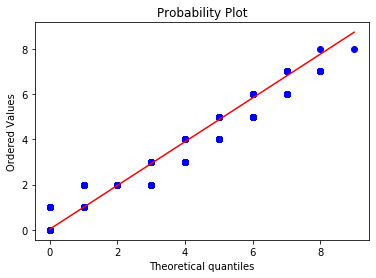

In [28]:
perform_test('levin2',N=2**20)